In [2]:
import pandas as pd
from fasttext import train_supervised, load_model
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/alex/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alex/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alex/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alex/.local/lib/python3.7/site-packages/tensorflow/python/framewo

In [3]:
from plot_cm import plot_cm
df = pd.read_csv('data/train.csv', usecols=['text', 'target'])\
  .rename(columns={'text': 'x', 'target': 'y'})

X, y = RandomUnderSampler(random_state=42).fit_resample(df[['x']].values, df['y'].values)
df = pd.DataFrame({'x': X[:, 0], 'y': y})

print(df.y.value_counts())
df.head()

1    3271
0    3271
Name: y, dtype: int64


,x,y
0,Everyday is a near death fatality for me on th...,0
1,#Lifestyle Û÷It makes me sickÛª: Baby clothe...,0
2,@Lenn_Len Probably. We are inundated with them...,0
3,A demoness with the voice of an angel. Like a ...,0
4,Next Man Up---AH SCREW THIS! I'm so tired of i...,0


In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['y'])
train_df = train_df.copy()
test_df = test_df.copy()


In [5]:
def preprocess(x):  return x.replace('\n', ' ').strip()

train_df['x'] = train_df['x'].map(preprocess)
test_df['x'] = test_df['x'].map(preprocess)

In [6]:
def save_df_in_fasttext_format(df, path, label_prefix='__label__'):
  with open(path, 'w+') as f:
    for _, row in df.iterrows():
      assert '\n' not in row['x']
      f.write('{}{} {}\n'.format(label_prefix, row['y'], row['x'].strip()))
      

def predict(model, df, label_prefix='__label__'):
  labels, probs = model.predict(df['x'].tolist())
  return [int(label_list[0].replace(label_prefix, '')) for label_list in labels]


save_df_in_fasttext_format(train_df, 'data/train.data')

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       655
           1       0.78      0.73      0.75       654

    accuracy                           0.76      1309
   macro avg       0.76      0.76      0.76      1309
weighted avg       0.76      0.76      0.76      1309



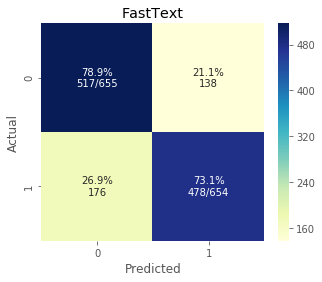

In [7]:
model = train_supervised(input='data/train.data',
                         epoch=25,
                         lr=1.0,
                         wordNgrams=2,
                         verbose=2,
                         minCount=1,
                         label='__label__')
model.save_model('ft.model')
test_df['y_pred'] = predict(model, test_df)

print(classification_report(test_df['y'], test_df['y_pred']))

plot_cm(test_df['y'], test_df['y_pred'], 'FastText')

In [70]:
print(test_df['y'].unique())
print(test_df['y_pred'].unique())

[0 1]
[1 0]


In [71]:
# model.quantize(input='data/train.data', qnorm=True, retrain=True, cutoff=100000)
# model.save_model('ft_quantized.model')

# print(classification_report(test_df['y'], predict(model, test_df)))

In [72]:
test_df = pd.read_csv('data/test.csv', usecols=['text'])\
  .rename(columns={'text': 'x'})
test_df['x'] = test_df['x'].map(preprocess)
test_df['y_pred'] = predict(model, test_df)

In [73]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission["target"] = test_df['y_pred']

In [74]:
sample_submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [75]:
sample_submission.to_csv("submissions/02_fasttext_submission.csv", index=False)

Score: 0.74437

TODO:
  - Following official latest guide https://fasttext.cc/docs/en/supervised-tutorial.html 
  - Automatic hyperparameter optimization https://fasttext.cc/docs/en/autotune.html

